# Quantum Computing

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Imports
from qiskit import IBMQ, Aer, assemble
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
import qiskit as q
# from qiskit.tools.visualization import plot_bloch_sphere
from qiskit.visualization import plot_histogram, matplotlib
import matplotlib.pyplot as plt
from utils import dotdict
from DeutschJozsa.DeutschJozsa import DeutschJozsa
from BernsteinVazirani.BernsteinVazirani import BernsteinVazirani
from Simons.Simons import Simons
import os

In [3]:
# Config
args = dotdict()
args.location = "local"  # local or remote
args.local_backend = "qasm_simulator"
args.remote_backend = ""
args.shots = 500

In [4]:
base_dir = 'imgs/'
circuit_dir = base_dir + 'alg/'

if not os.path.exists(base_dir):
    os.mkdir(base_dir)

if not os.path.exists(circuit_dir):
    os.mkdir(circuit_dir)

In [5]:
def save_circuit(circuit, name=None):
    if name is None:
        name = alg.name + '_alg'
    return circuit.draw(output="mpl").savefig(circuit_dir + name + '.pdf')

## Entanglement

In [6]:
qc = q.QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
print(qc)

     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘


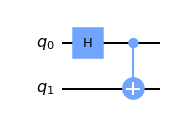

In [7]:
save_circuit(qc, "entanglement")

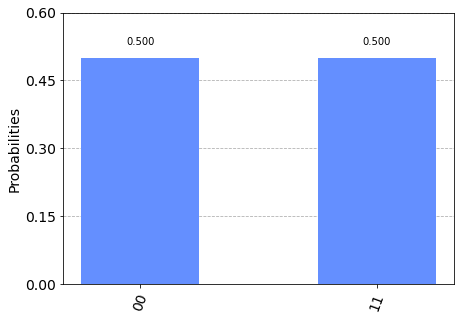

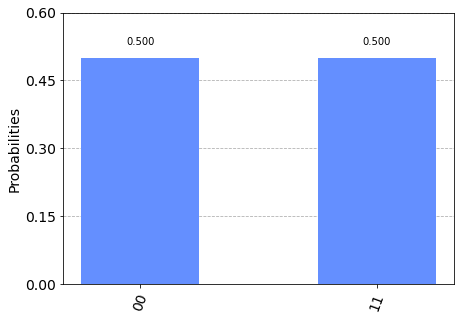

In [8]:
# Run on simulation
qobj = assemble(qc)
svsim = Aer.get_backend('statevector_simulator')
result = svsim.run(qobj).result()
plot_histogram(result.get_counts())

In [9]:
# Run on remote QC
qc.measure_all()

IBMQ.save_account(open("token.txt", "r").read())
factory = IBMQ.load_account()
devices = factory.backends(filters=lambda x: x.configuration().n_qubits > 1 and
                                                   not x.configuration().simulator)
backend = least_busy(devices)

#IBMQ.enable_account(open("token.txt", "r").read())


job = q.execute(qc, backend, shots=500)
job_monitor(job)
result = job.result()


configrc.store_credentials:WARNING:2021-05-12 14:56:09,325: Credentials already present. Set overwrite=True to overwrite.
Job Status: job has successfully run


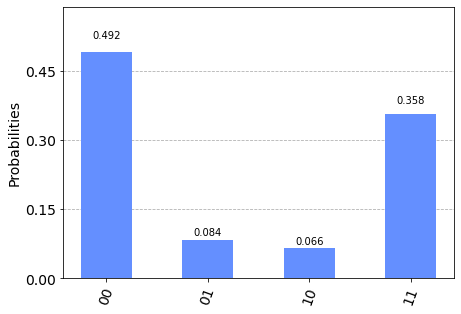

In [10]:
plot_histogram(result.get_counts()).savefig('test')

In [11]:
print(job.result().get_counts(qc))

{'00': 246, '01': 42, '10': 33, '11': 179}



Shor Code
--------------
Job Status: job has successfully run

 Uncorrected bit flip and phase error
--------------------------------------
{'1': 1000}
Job Status: job has successfully run

Shor code with bit flip and phase error
----------------------------------------
{'0': 1000}


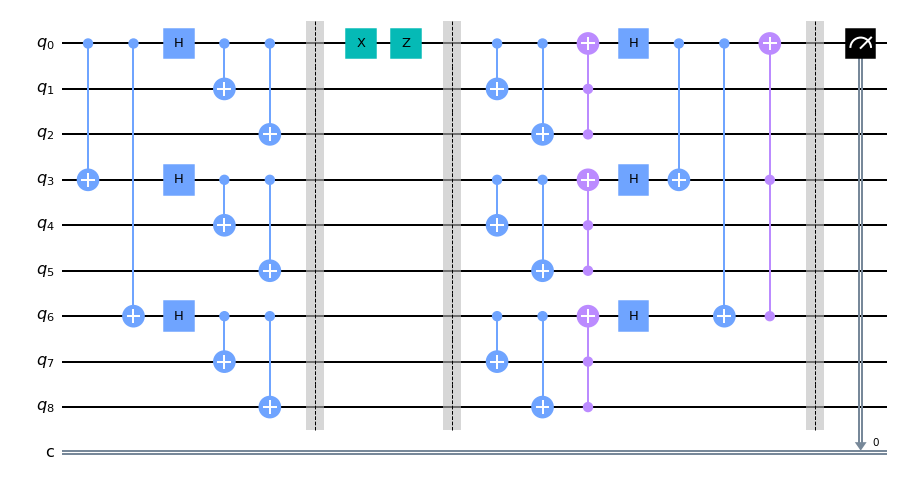

In [12]:
print('\nShor Code')
print('--------------')

from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from qiskit import QuantumCircuit, execute,IBMQ
from qiskit.tools.monitor import job_monitor

#IBMQ.enable_account(open("token.txt", "r").read())
provider = IBMQ.get_provider(hub='ibm-q')

backend = provider.get_backend('ibmq_qasm_simulator')

q = QuantumRegister(1,'q')
c = ClassicalRegister(1,'c')

circuit = QuantumCircuit(q,c)

circuit.h(q[0])

####error here############
circuit.x(q[0])#Bit flip error
circuit.z(q[0])#Phase flip error
############################

circuit.h(q[0])

circuit.barrier(q)

circuit.measure(q[0],c[0])

job = execute(circuit, backend, shots=1000)

job_monitor(job)

counts = job.result().get_counts()

print("\n Uncorrected bit flip and phase error")
print("--------------------------------------")
print(counts)

#####Shor code starts here ########
q = QuantumRegister(9,'q')
c = ClassicalRegister(1,'c')

circuit = QuantumCircuit(q,c)

circuit.cx(q[0],q[3])
circuit.cx(q[0],q[6])

circuit.h(q[0])
circuit.h(q[3])
circuit.h(q[6])

circuit.cx(q[0],q[1])
circuit.cx(q[3],q[4])
circuit.cx(q[6],q[7])

circuit.cx(q[0],q[2])
circuit.cx(q[3],q[5])
circuit.cx(q[6],q[8])

circuit.barrier(q)

####error here############
circuit.x(q[0])#Bit flip error
circuit.z(q[0])#Phase flip error
############################

circuit.barrier(q)
circuit.cx(q[0],q[1])
circuit.cx(q[3],q[4])
circuit.cx(q[6],q[7])

circuit.cx(q[0],q[2])
circuit.cx(q[3],q[5])
circuit.cx(q[6],q[8])

circuit.ccx(q[1],q[2],q[0])
circuit.ccx(q[4],q[5],q[3])
circuit.ccx(q[8],q[7],q[6])

circuit.h(q[0])
circuit.h(q[3])
circuit.h(q[6])

circuit.cx(q[0],q[3])
circuit.cx(q[0],q[6])
circuit.ccx(q[6],q[3],q[0])

circuit.barrier(q)

circuit.measure(q[0],c[0])

circuit.draw(output='mpl',filename='shorcode.png') #Draws an image of the circuit

job = execute(circuit, backend, shots=1000)

job_monitor(job)

counts = job.result().get_counts()

print("\nShor code with bit flip and phase error")
print("----------------------------------------")
print(counts)

In [13]:
print(job.result())

Result(backend_name='ibmq_qasm_simulator', backend_version='0.8.1', qobj_id='70443643-e8ad-4e28-a38a-fbae2c07b2b7', job_id='609bd08a77207894d790c4b0', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=MeasLevel.CLASSIFIED, data=ExperimentResultData(counts={'0x0': 1000}), header=QobjExperimentHeader(clbit_labels=[['c', 0]], creg_sizes=[['c', 1]], global_phase=0.0, memory_slots=1, metadata={}, n_qubits=9, name='circuit-114', qreg_sizes=[['q', 9]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4], ['q', 5], ['q', 6], ['q', 7], ['q', 8]]), status=DONE, metadata={'fusion': {'applied': False, 'enabled': True, 'max_fused_qubits': 5, 'threshold': 14}, 'measure_sampling': True, 'method': 'statevector', 'parallel_shots': 1, 'parallel_state_update': 16}, seed_simulator=3744075424, time_taken=0.001776788)], date=2021-05-12 14:56:44.612716+02:00, status=COMPLETED, status=QobjHeader(backend_name='ibmq_qasm_simulator', backend_version='0.1.547'), metadata={'ma

In [14]:
print(counts)

{'0': 1000}


In [15]:
job.result().get_counts()

{'0': 1000}

## DeutschJozsa

In [16]:
# Config
args.deutsch_jozsa_n = 3
args.deutsch_jozsa_oracle = 'constant' # balanced or constant

In [17]:
# Algorithm
alg = DeutschJozsa(args)

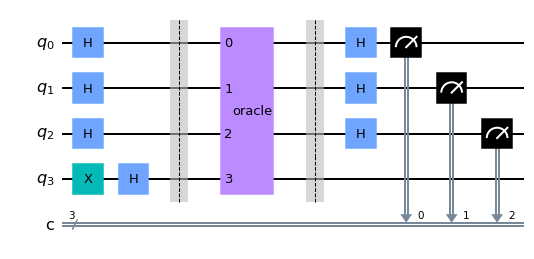

In [18]:
# Circuit
save_circuit(alg.circuit)

In [19]:
# Run
result = alg.run()

Job Status: job has successfully run


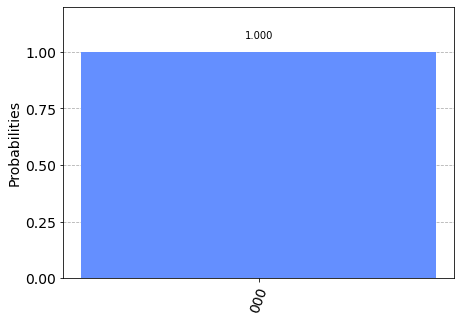

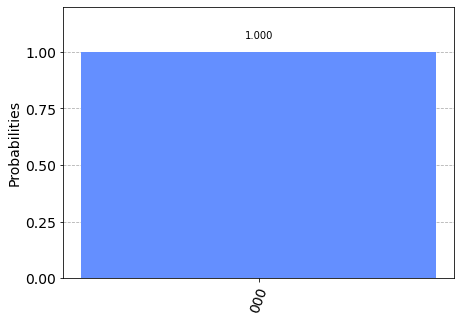

In [20]:
# Result
counts = result.get_counts(alg.circuit)
plot_histogram([counts])

In [21]:
# Save results.
alg.save_results()

{"counts": {"0x0": 500}}


## Bernstein-Vazirani Algorithm

In [22]:
# Config
args.bernstein_vazirani_s = '1001'

In [23]:
# Algorithm
alg = BernsteinVazirani(args)

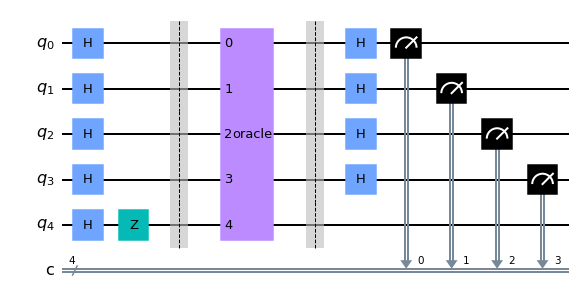

In [24]:
# Circuit
save_circuit(alg.circuit)

In [25]:
# Run
result = alg.run()

Job Status: job has successfully run


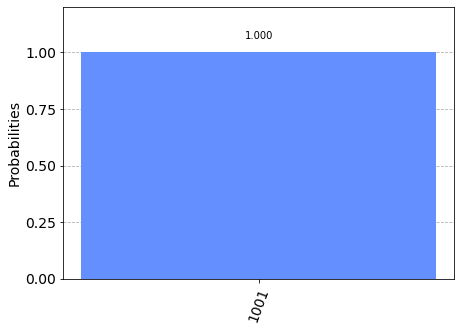

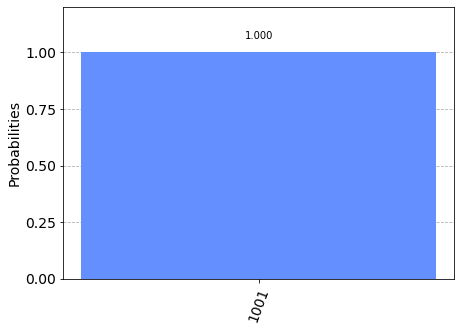

In [26]:
# Result
counts = result.get_counts(alg.circuit)
plot_histogram([counts])

In [27]:
# Save results.
alg.save_results()

{"counts": {"0x9": 500}}


## Simon's Algorithm

In [28]:
# Config
args.simons_b = '1001'

In [29]:
# Algorithm
alg = Simons(args)

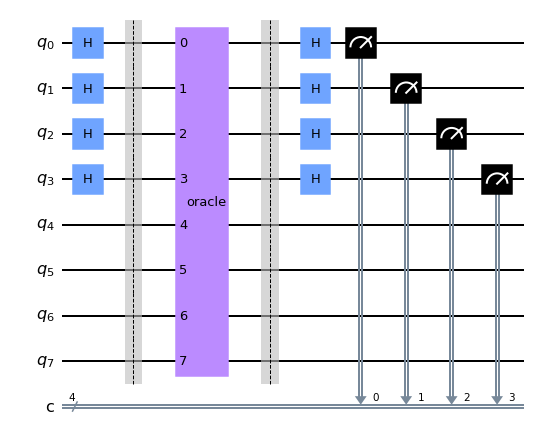

In [30]:
# Circuit
save_circuit(alg.circuit)

In [31]:
# Run
result = alg.run()

Job Status: job has successfully run


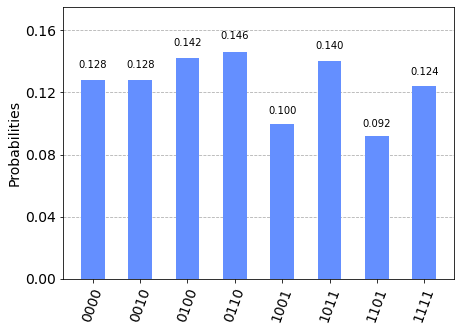

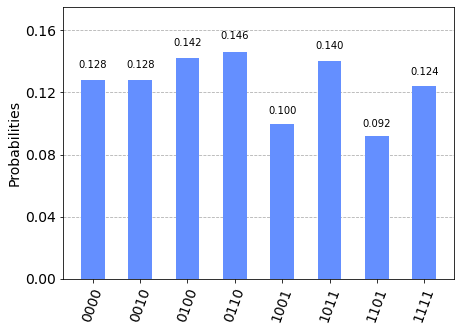

In [32]:
# Result
counts = result.get_counts(alg.circuit)
plot_histogram([counts])

In [33]:
# Save results.
alg.save_results()

{"counts": {"0xf": 62, "0x6": 73, "0x2": 64, "0xb": 70, "0x4": 71, "0xd": 46, "0x9": 50, "0x0": 64}}


## Fourier?

## Hybrid Network

In [34]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

from HybridNet.HybridNet import QuantumCircuit, Net
from utils import dotdict

Expected value for rotation pi 0.51
        ┌───┐ ░ ┌───────────┐ ░ ┌─┐
   q_0: ┤ H ├─░─┤ RY(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0 


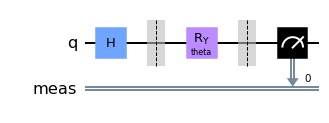

In [35]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
print(circuit._circuit)
# TODO Save image
save_circuit(circuit._circuit, 'quantum_hybrid_net_circuit')

In [36]:
# Training data.
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                            transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples],
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

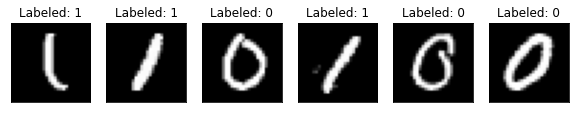

In [37]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))

    n_samples_show -= 1

plt.show()

In [38]:
# Testing data
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)


In [38]:
# Training the model.
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())

    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

c:\Users\janni\Projects\TH Koeln Master\AVS\QuantumComputing\HybridNet\HybridNet.py:91: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T
Training [5%]	Loss: -0.7360
Training [10%]	Loss: -0.9087
Training [15%]	Loss: -0.9253
Training [20%]	Loss: -0.9460
Training [25%]	Loss: -0.9453
Training [30%]	Loss: -0.9619
Training [35%]	Loss: -0.9613


KeyboardInterrupt: 

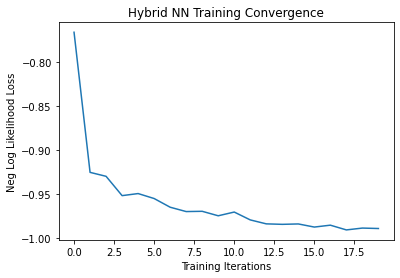

In [39]:
# Plot training.
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')
plt.show()

In [40]:
# Evaluating the model.
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100))

Performance on test data:
	Loss: -0.9806
	Accuracy: 100.0%


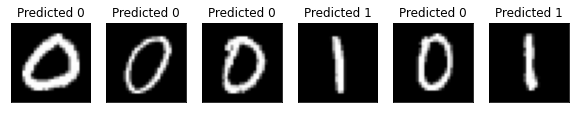

In [41]:
# Testing the model.
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1

In [42]:
# Visualize the network.
from torchviz import make_dot
x = torch.randn(1, 1, 28, 28)
yhat = model(x)
make_dot(yhat, params=dict(model.named_parameters()))

ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH